In [1]:
import os, re, random, math
from pathlib import Path
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from IPython.display import Audio, display
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import GroupShuffleSplit
import torch.nn as nn
from torchinfo import summary
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Torch: 2.8.0+cu128 | CUDA: True


In [2]:
DATASET_ROOT = "TESS Dataset"   
root = Path(DATASET_ROOT)
assert root.exists(), f"Path not found: {root}"

EMOTIONS = ["angry","disgust","fear","happy","neutral","pleasant_surprise","sad"]

# Map common variants to canonical names
EMOTION_ALIASES = {
    "angry":"angry",
    
    "disgust":"disgust",
    
    "fear":"fear",
    
    "happy":"happy",
    
    "neutral":"neutral",
    
    "ps": "pleasant_surprise", "pleasant": "pleasant_surprise", "surprise": "pleasant_surprise", 
    "pleasant_surprise": "pleasant_surprise",
    
    "sad":"sad"
}

GROUP_TOKENS = {"yaf","oaf"}

def parse_word_from_filename(path):
    name = path.stem  
    toks = re.split(r"[_\-\s]+", name.lower())

    emo = None
    for t in reversed(toks):
        if t in EMOTION_ALIASES:
            emo = EMOTION_ALIASES[t]
            break

    # Pick the first token that is not group and not emotion
    for t in toks:
        if t in GROUP_TOKENS: 
            continue
        
        # Allowing 'pleasant' or 'surprise' to be filtered if they are the emo pieces
        if emo == "pleasant_surprise" and t in {"pleasant","surprise","pleasant_surprise","ps"}:
            continue
        if emo is not None and t == emo:
            continue
        return t  

    return None

def pick_common_word(all_items, emotion):
    yaf_words = set()
    oaf_words = set()
    for d in all_items:
        if d["emotion"] != emotion:
            continue
        w = parse_word_from_filename(d["path"])
        if w is None:
            continue
        if d["group"] == "YAF":
            yaf_words.add(w)
        elif d["group"] == "OAF":
            oaf_words.add(w)

    common = sorted(yaf_words & oaf_words)
    if not common:
        return None
    return random.choice(common)

In [3]:
def parse_group_emotion(folder_name: str):
    toks = re.split(r"[_\-\s]+", folder_name.strip())
    grp = next((t.upper() for t in toks if t.upper() in ("YAF","OAF")), None)
    emo = None
    for t in reversed(toks):
        tl = t.lower()
        if tl in EMOTION_ALIASES:
            emo = EMOTION_ALIASES[tl]
            break
    return grp, emo

all_items = []
for sub in root.iterdir():
    if not sub.is_dir():
        continue
    grp, emo = parse_group_emotion(sub.name)
    if grp in ("YAF","OAF") and emo in EMOTIONS:
        for wav in sub.glob("*.wav"):
            all_items.append({"path": wav, "group": grp, "emotion": emo})

print(f"Total wavs found: {len(all_items)}\n")
print("By Emotion:", dict(Counter([d["emotion"] for d in all_items])))
print("By Group:  ", dict(Counter([d["group"] for d in all_items])))

Total wavs found: 2800

By Emotion: {'happy': 400, 'fear': 400, 'sad': 400, 'neutral': 400, 'pleasant_surprise': 400, 'angry': 400, 'disgust': 400}
By Group:   {'OAF': 1400, 'YAF': 1400}


In [4]:
def waveplot(data, sr, title):
    plt.figure(figsize=(7, 3))
    plt.title(title, fontsize=12)
    librosa.display.waveshow(y=data, sr=sr)
    plt.xlabel("Time(in sec.)")
    plt.tight_layout()
    plt.show()

def spectrogram(data, sr, title, n_fft=1024, hop_length=256):
    D = librosa.stft(data, n_fft=n_fft, hop_length=hop_length, window="hann")
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure(figsize=(8, 4))
    plt.title(title, fontsize=12)
    # use valid axis keywords
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', hop_length=hop_length)
    plt.colorbar(label="dB")
    plt.xlabel("Time(in sec.)")
    plt.ylabel("Frequency(in Hz.)")
    plt.tight_layout()
    plt.show()

In [5]:
def show_emotion_pair_same_word(all_items, emotion, sr=None):
    word = pick_common_word(all_items, emotion)
    if word is None:
        print(f"No common word found for emotion '{emotion}'.")
        return

    def find_path(group):
        candidates = [
            d["path"] for d in all_items
            if d["emotion"] == emotion and d["group"] == group and parse_word_from_filename(d["path"]) == word
        ]
        return random.choice(candidates) if candidates else None

    p_yaf = find_path("YAF")
    p_oaf = find_path("OAF")

    print(f"Emotion: {emotion}\n")

    for grp, p in [("YAF", p_yaf), ("OAF", p_oaf)]:
        if p is None:
            print(f"[{emotion}] No file found for group {grp} with word '{word}'")
            continue

        data, sampling_rate = librosa.load(str(p), sr=sr, mono=True)

        # Audio
        print(f"Emotion:{emotion} & Group: {grp} | File Name: {p.name}")
        display(Audio(data=data, rate=sampling_rate))

        # Wave Plot
        waveplot(data, sampling_rate, f"Wave Plot of {grp} | Emotion: {emotion} ")

        # Spectrogram
        spectrogram(data, sampling_rate, f"Spectrogram of {grp} | Emotion: {emotion} ")

Emotion: angry

Emotion:angry & Group: YAF | File Name: YAF_half_angry.wav


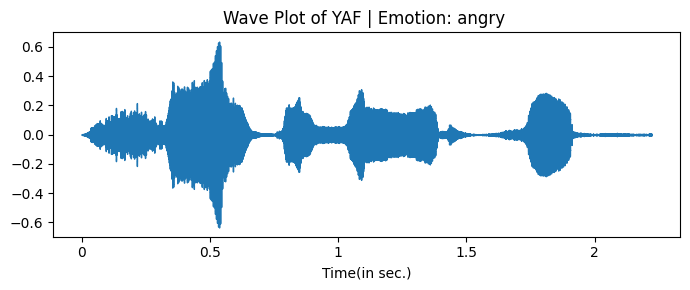

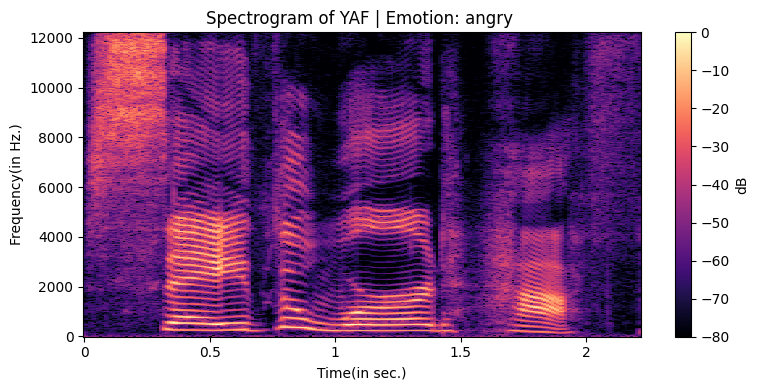

Emotion:angry & Group: OAF | File Name: OAF_half_angry.wav


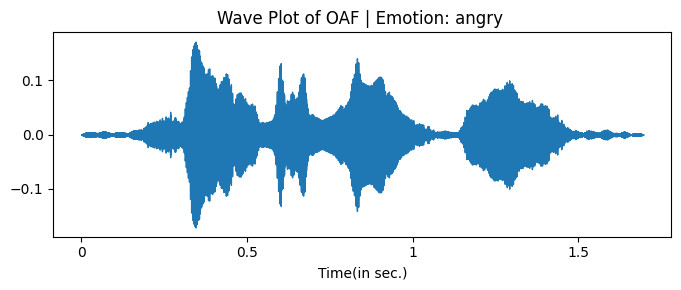

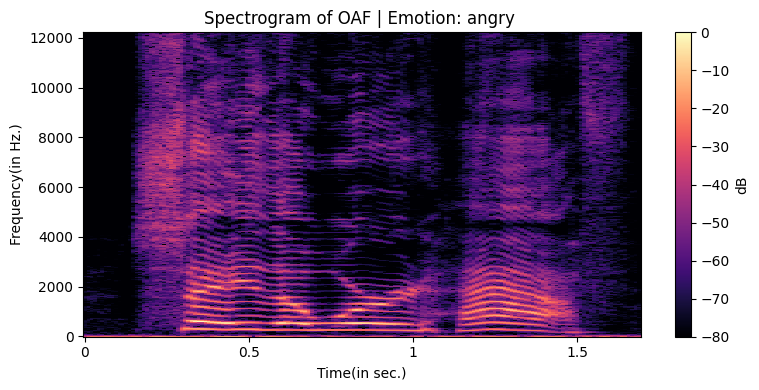

In [6]:
show_emotion_pair_same_word(all_items, "angry", sr=None)

Emotion: disgust

Emotion:disgust & Group: YAF | File Name: YAF_mode_disgust.wav


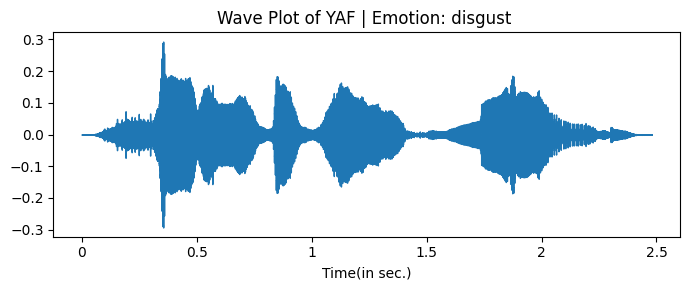

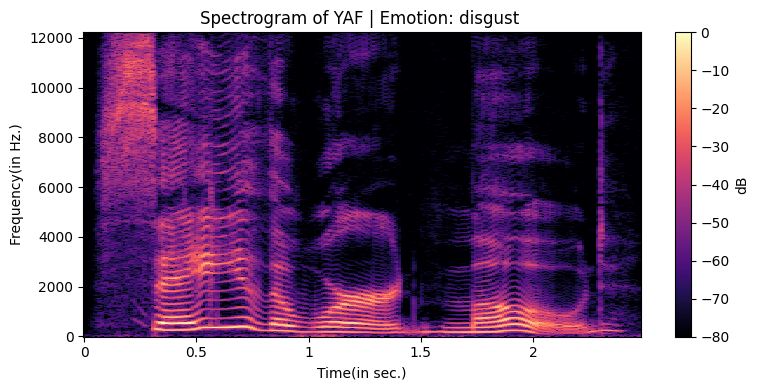

Emotion:disgust & Group: OAF | File Name: OAF_mode_disgust.wav


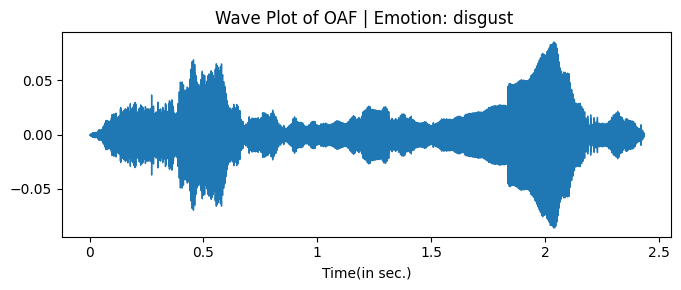

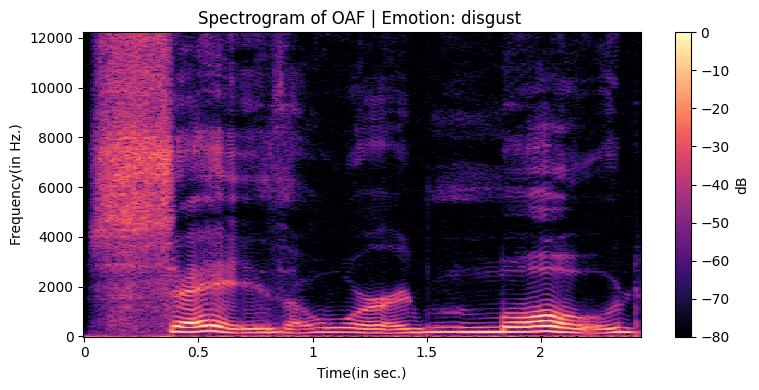

In [7]:
show_emotion_pair_same_word(all_items, "disgust", sr=None)

Emotion: fear

Emotion:fear & Group: YAF | File Name: YAF_south_fear.wav


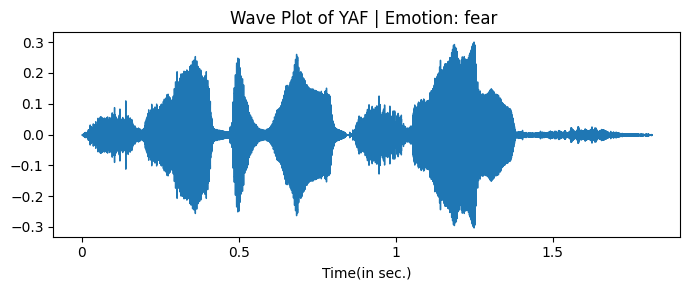

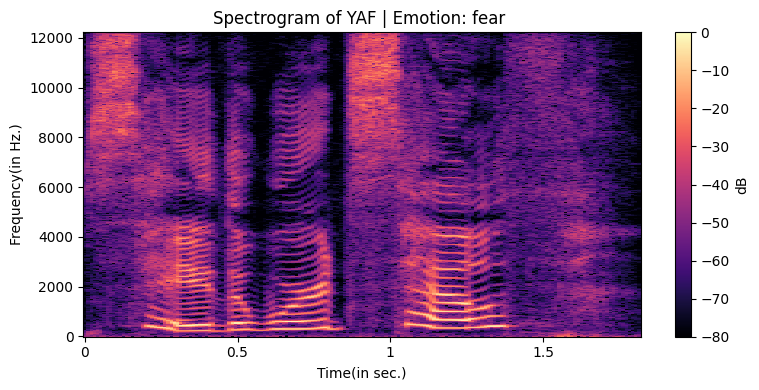

Emotion:fear & Group: OAF | File Name: OAF_south_fear.wav


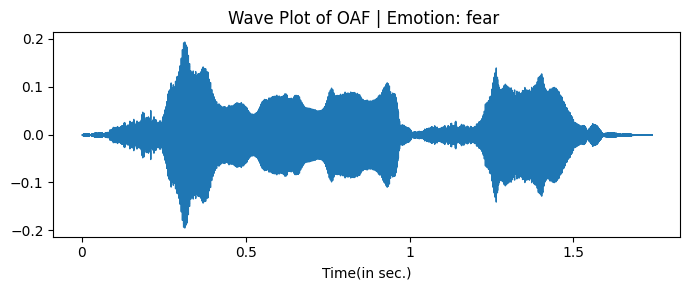

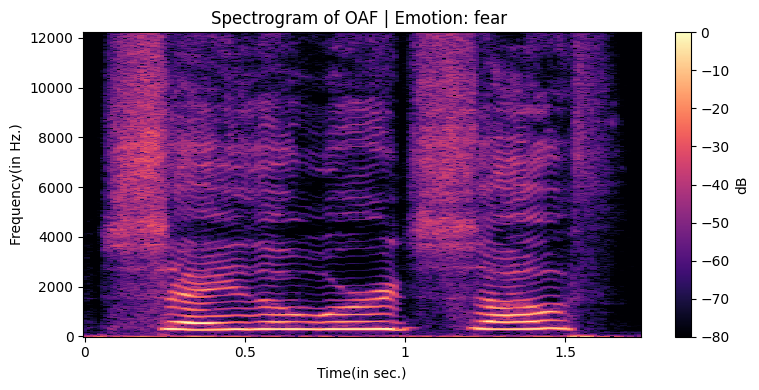

In [8]:
show_emotion_pair_same_word(all_items, "fear", sr=None)

Emotion: happy

Emotion:happy & Group: YAF | File Name: YAF_numb_happy.wav


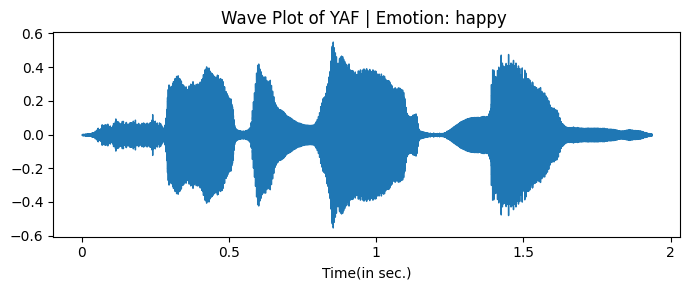

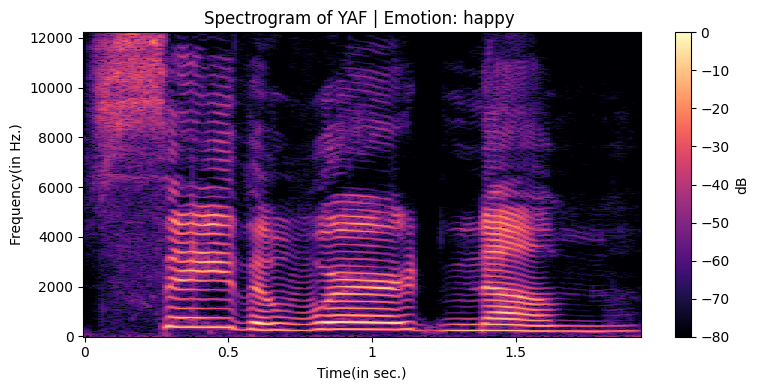

Emotion:happy & Group: OAF | File Name: OAF_numb_happy.wav


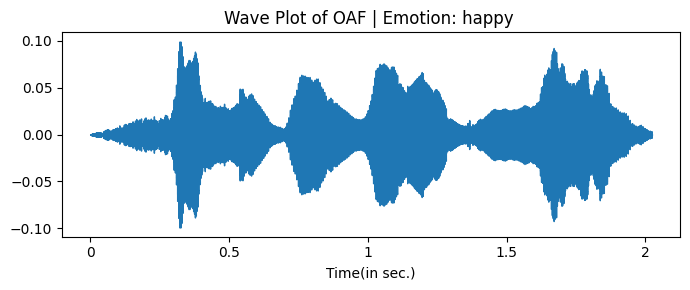

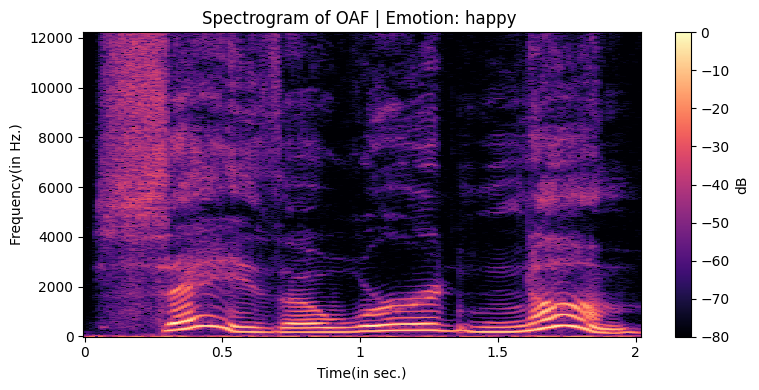

In [9]:
show_emotion_pair_same_word(all_items, "happy", sr=None)

Emotion: neutral

Emotion:neutral & Group: YAF | File Name: YAF_wife_neutral.wav


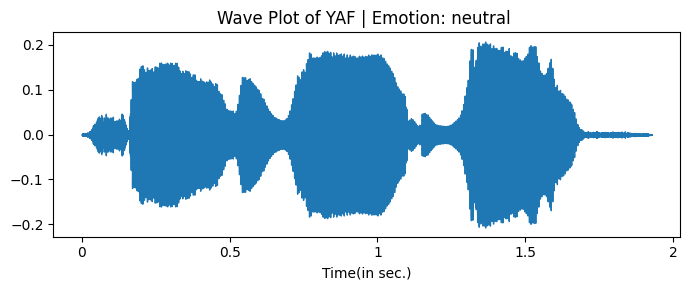

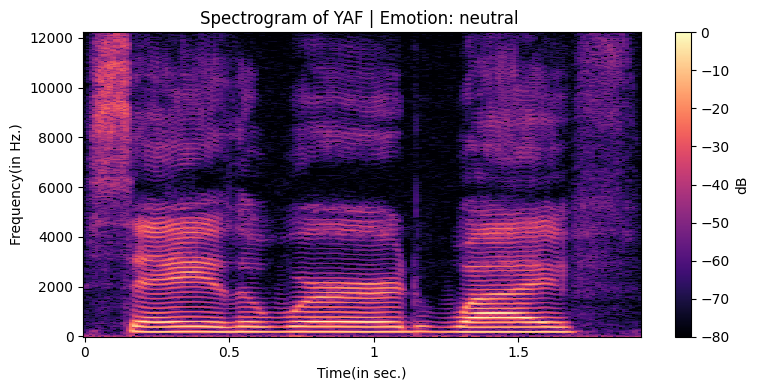

Emotion:neutral & Group: OAF | File Name: OAF_wife_neutral.wav


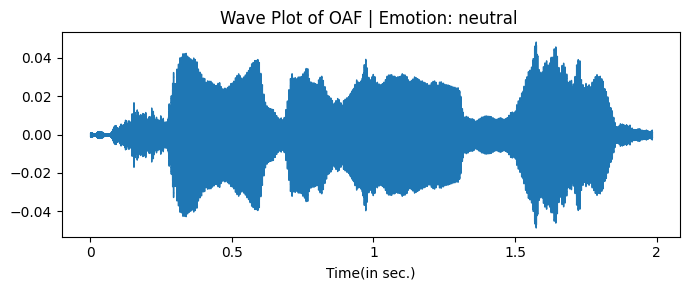

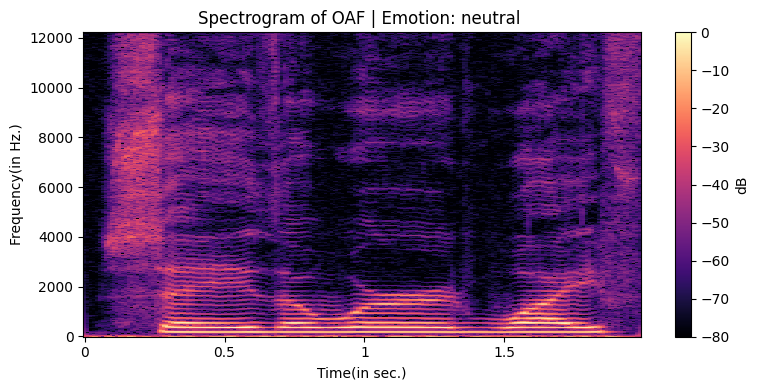

In [10]:
show_emotion_pair_same_word(all_items, "neutral", sr=None)

Emotion: pleasant_surprise

Emotion:pleasant_surprise & Group: YAF | File Name: YAF_near_ps.wav


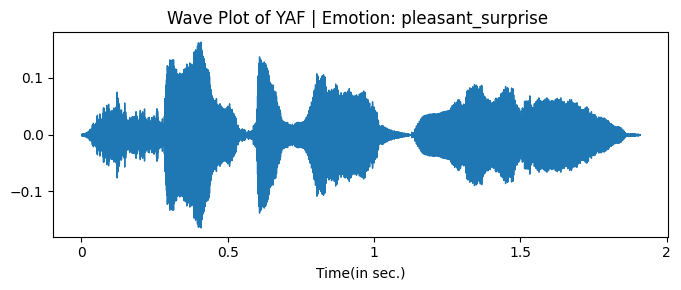

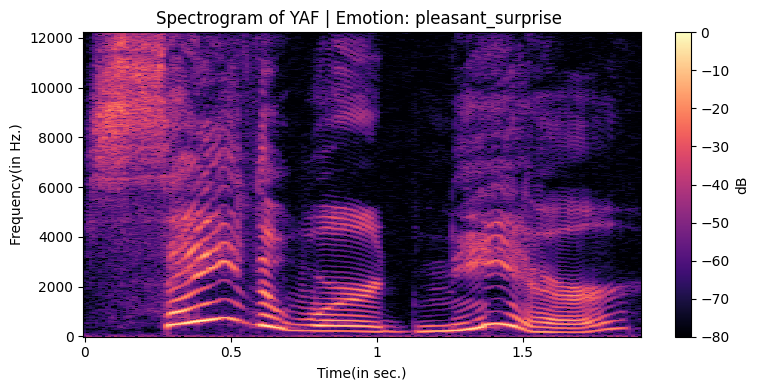

Emotion:pleasant_surprise & Group: OAF | File Name: OAF_near_ps.wav


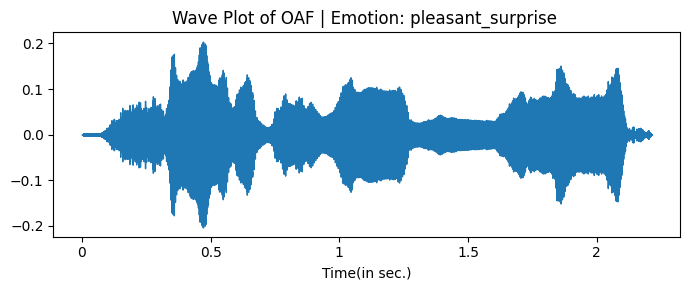

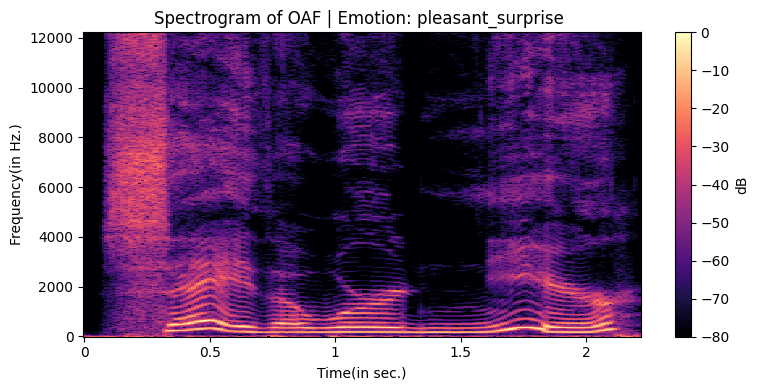

In [11]:
show_emotion_pair_same_word(all_items, "pleasant_surprise", sr=None)

Emotion: sad

Emotion:sad & Group: YAF | File Name: YAF_life_sad.wav


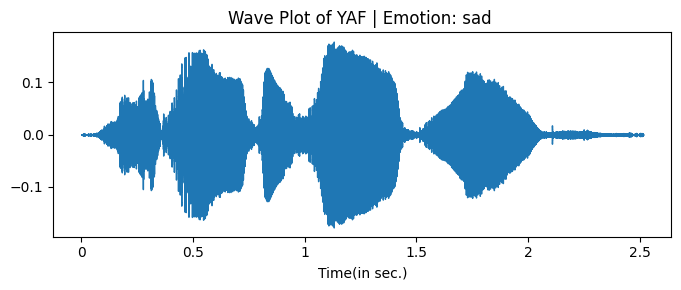

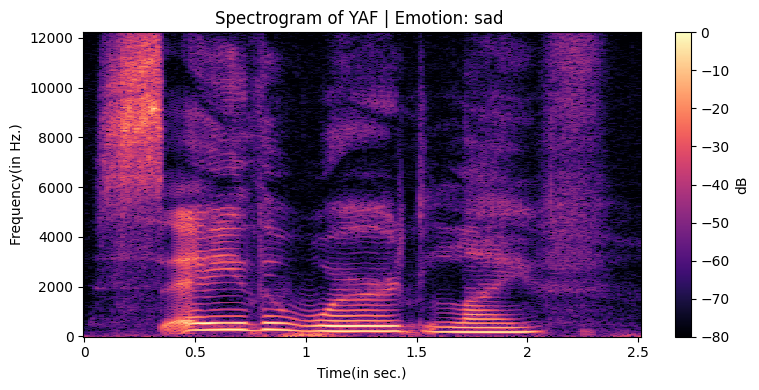

Emotion:sad & Group: OAF | File Name: OAF_life_sad.wav


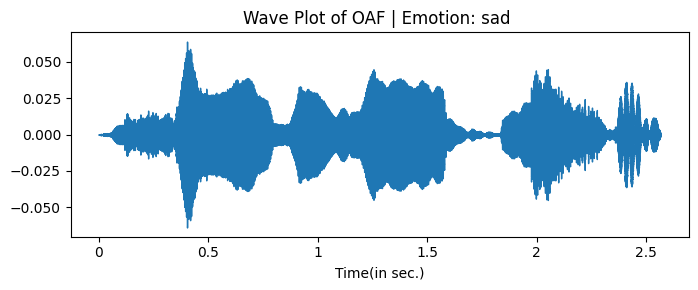

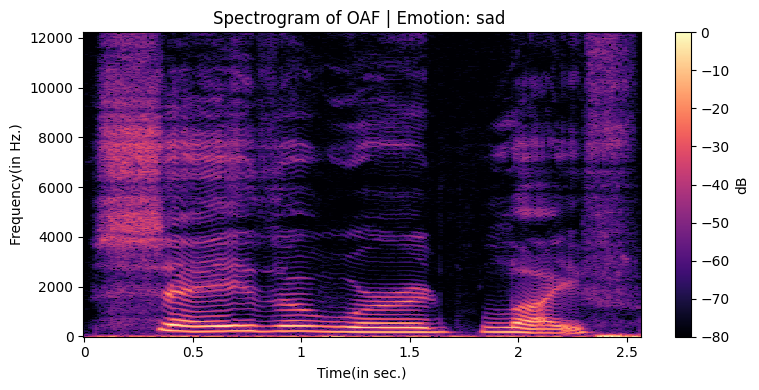

In [12]:
show_emotion_pair_same_word(all_items, "sad", sr=None)

In [13]:
N_MELS = 64
N_FFT = 1024
HOP_LENGTH = 256
FMIN, FMAX = 50, 8000

def extract_mel(path, target_sr=16000, clip_s=4.0):
    y, sr = librosa.load(path, sr=target_sr, mono=True)
    Treq = int(target_sr * clip_s)
    if len(y) < Treq:
        y = np.pad(y, (0, Treq - len(y)))
    else:
        y = y[:Treq]

    mel = librosa.feature.melspectrogram(
        y=y,                      
        sr=target_sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS,
        fmin=FMIN,
        fmax=FMAX)
    
    mel_db = librosa.power_to_db(S=mel, ref=np.max) 
    mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-9)
    return mel_db.T 

class TESSDataset(Dataset):
    def __init__(self, items):
        self.items = items
        self.classes = sorted(set(d["emotion"] for d in items))
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path = self.items[idx]["path"]
        emotion = self.items[idx]["emotion"]
        X = extract_mel(path)                 
        y = self.class_to_idx[emotion]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

In [14]:
groups = [parse_word_from_filename(d["path"]) for d in all_items]

gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(gss.split(all_items, groups=groups))
train_items = [all_items[i] for i in train_idx]
test_items  = [all_items[i] for i in test_idx]

train_groups = [parse_word_from_filename(d["path"]) for d in train_items]
gss_val = GroupShuffleSplit(n_splits=1, test_size=0.10, random_state=43)
tr_idx, val_idx = next(gss_val.split(train_items, groups=train_groups))
train_items, val_items = [train_items[i] for i in tr_idx], [train_items[i] for i in val_idx]

train_ds = TESSDataset(train_items)
val_ds   = TESSDataset(val_items)
test_ds  = TESSDataset(test_items)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

In [15]:
class AttnPool(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.w = nn.Linear(d, 1)
    def forward(self, x):                                 # x: [B, T, D]
        a = torch.softmax(self.w(x).squeeze(-1), dim=1)   # [B, T]
        return (x * a.unsqueeze(-1)).sum(dim=1)           # [B, D]

class EmotionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=2, num_classes=7, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)
        self.attn = AttnPool(2*hidden_size)
        self.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(2*hidden_size, num_classes))
        
    def forward(self, x):
        out, _ = self.lstm(x)           # [B, T, 512]
        out = self.attn(out)            # [B, 512]
        return self.fc(out)

In [16]:
sample_mel = extract_mel(train_items[0]['path'])   
time_steps, mel_bins = sample_mel.shape

model = EmotionLSTM(input_size=mel_bins, num_classes=len(train_ds.classes)).to(device)

summary(
    model,
    input_size=(1, time_steps, mel_bins),  # (batch, time, n_mels)
    col_names=("input_size", "output_size", "num_params", "kernel_size"),
    col_width=18,
    row_settings=("var_names", "depth")
)

Layer (type (var_name):depth-idx)        Input Shape        Output Shape       Param #            Kernel Shape
EmotionLSTM (EmotionLSTM)                [1, 251, 64]       [1, 7]             --                 --
├─LSTM (lstm): 1-1                       [1, 251, 64]       [1, 251, 512]      2,236,416          --
├─AttnPool (attn): 1-2                   [1, 251, 512]      [1, 512]           --                 --
│    └─Linear (w): 2-1                   [1, 251, 512]      [1, 251, 1]        513                --
├─Sequential (fc): 1-3                   [1, 512]           [1, 7]             --                 --
│    └─Dropout (0): 2-2                  [1, 512]           [1, 512]           --                 --
│    └─Linear (1): 2-3                   [1, 512]           [1, 7]             3,591              --
Total params: 2,240,520
Trainable params: 2,240,520
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 561.34
Input size (MB): 0.06
Forward/backward pass size (MB): 1.03
Para

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionLSTM(input_size=N_MELS, num_classes=len(train_ds.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val_acc = 0.0
best_state = None

In [18]:
# Early stopping + LR scheduler config
EPOCHS = 30          
PATIENCE = 5         
MIN_DELTA = 1e-3     

epochs_no_improve = 0

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2, min_lr=1e-5)

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        correct += (outputs.argmax(1) == y).sum().item()
        total += y.size(0)

    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item() * y.size(0)
            val_correct += (outputs.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_acc = val_correct / val_total

    # Early stopping check 
    improvement = val_acc - best_val_acc
    if improvement > MIN_DELTA:
        best_val_acc = val_acc
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    scheduler.step(val_acc)

    if epochs_no_improve >= PATIENCE:
        print(f"🛑 Early stopping: no improvement > {MIN_DELTA} for {PATIENCE} epochs.")
        break

    print(f"Epoch {epoch+1:02d}/30 | "
          f"Train Loss: {total_loss/total:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss/val_total:.4f} | Val Acc: {val_acc:.4f}")

    # Saving the best 
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

Epoch 01/30 | Train Loss: 0.8349 | Train Acc: 0.6938 | Val Loss: 0.3965 | Val Acc: 0.8839
Epoch 02/30 | Train Loss: 0.1450 | Train Acc: 0.9548 | Val Loss: 0.0896 | Val Acc: 0.9732
Epoch 03/30 | Train Loss: 0.1142 | Train Acc: 0.9648 | Val Loss: 0.0804 | Val Acc: 0.9732
Epoch 04/30 | Train Loss: 0.0604 | Train Acc: 0.9821 | Val Loss: 0.0637 | Val Acc: 0.9777
Epoch 05/30 | Train Loss: 0.0803 | Train Acc: 0.9772 | Val Loss: 0.0604 | Val Acc: 0.9911
Epoch 06/30 | Train Loss: 0.0353 | Train Acc: 0.9896 | Val Loss: 0.0222 | Val Acc: 0.9911
Epoch 07/30 | Train Loss: 0.0051 | Train Acc: 0.9985 | Val Loss: 0.0193 | Val Acc: 0.9911
Epoch 08/30 | Train Loss: 0.0012 | Train Acc: 1.0000 | Val Loss: 0.0249 | Val Acc: 0.9911
Epoch 09/30 | Train Loss: 0.0006 | Train Acc: 1.0000 | Val Loss: 0.0243 | Val Acc: 0.9911
🛑 Early stopping: no improvement > 0.001 for 5 epochs.


In [19]:
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
print(f"✅ Best Val. Accuracy: {best_val_acc*100:.2f}%")

✅ Best Val. Accuracy: 99.11%


In [20]:
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_trues.extend(y.cpu().numpy().tolist())

idx_to_class = {i: c for i, c in enumerate(train_ds.classes)}

test_acc = np.mean(np.array(all_preds) == np.array(all_trues))
print(f"✅ Testing Accuracy: {test_acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(
    [idx_to_class[i] for i in all_trues],
    [idx_to_class[i] for i in all_preds],
    digits=3))

✅ Testing Accuracy: 98.57%

Classification Report:
                   precision    recall  f1-score   support

            angry      1.000     0.988     0.994        80
          disgust      0.941     1.000     0.970        80
             fear      0.964     1.000     0.982        80
            happy      1.000     0.963     0.981        80
          neutral      1.000     1.000     1.000        81
pleasant_surprise      1.000     0.950     0.974        80
              sad      1.000     1.000     1.000        80

         accuracy                          0.986       561
        macro avg      0.986     0.986     0.986       561
     weighted avg      0.986     0.986     0.986       561



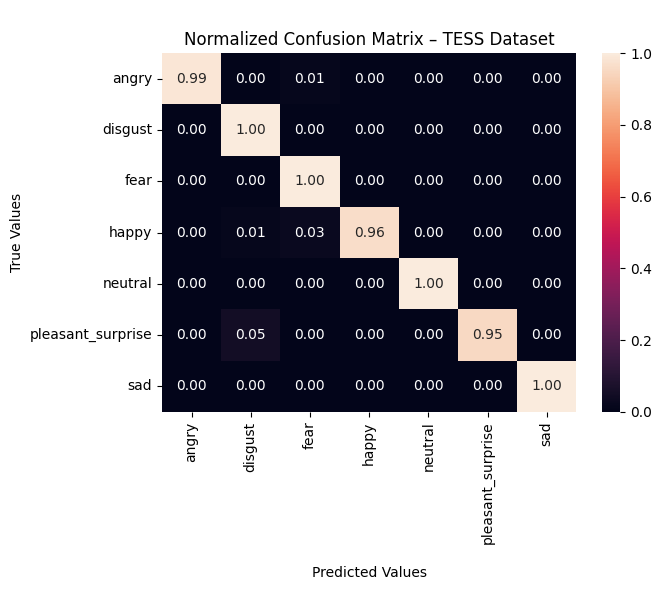

In [21]:
cm = confusion_matrix(all_trues, all_preds, labels=list(idx_to_class.keys()))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f",
            xticklabels=[idx_to_class[i] for i in idx_to_class],
            yticklabels=[idx_to_class[i] for i in idx_to_class])
plt.xlabel("\nPredicted Values")
plt.ylabel("True Values")
plt.title("\nNormalized Confusion Matrix – TESS Dataset")
plt.tight_layout()
plt.show()

True Emotion: sad | Predicted Emotion: sad



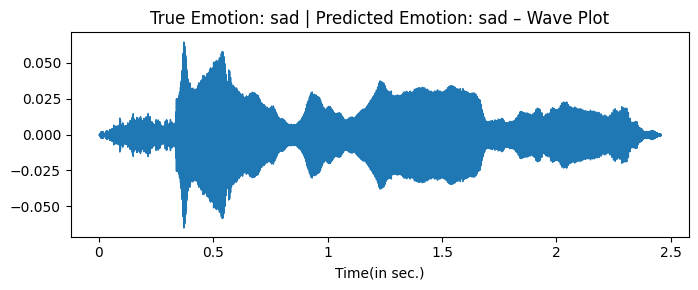

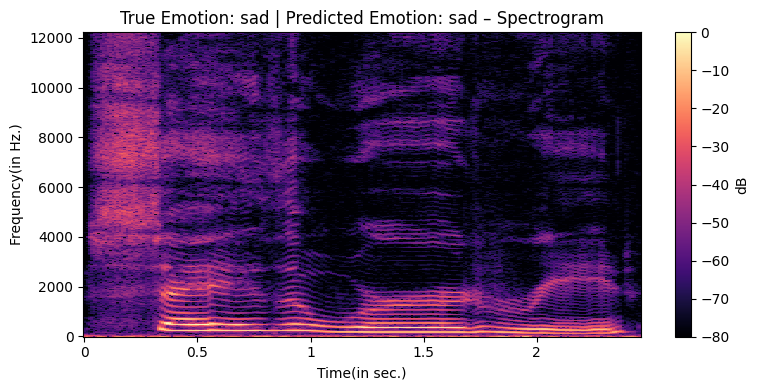

In [22]:
# Picking a random Test sample
i = random.randrange(len(test_ds))
X, y = test_ds[i]
true_label = train_ds.classes[y.item()]

model.eval()
with torch.no_grad():
    pred_idx = model(X.unsqueeze(0).to(device)).argmax(1).item()
pred_label = train_ds.classes[pred_idx]

print(f"True Emotion: {true_label} | Predicted Emotion: {pred_label}\n")

# Original audio path tied to this sample
path = test_items[i]["path"]
audio_data, sampling_rate = librosa.load(str(path), sr=None, mono=True)

# Audio
display(Audio(data=audio_data, rate=sampling_rate))

# Wave Plot
waveplot(audio_data, sampling_rate, f"True Emotion: {true_label} | Predicted Emotion: {pred_label} – Wave Plot")

# Spectrogram
spectrogram(audio_data, sampling_rate, f"True Emotion: {true_label} | Predicted Emotion: {pred_label} – Spectrogram")

In [30]:
!jupyter nbconvert --to html Vibe_Voice_Project.ipynb

[NbConvertApp] Converting notebook Vibe_Voice_Project.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 31 image(s).
[NbConvertApp] Writing 7322038 bytes to Vibe_Voice_Project.html
